### importing 

In [83]:
%load_ext autoreload
%autoreload 2 
import pandas as pd
import numpy as np
import pdfplumber
import re
import nltk
from urllib.parse import urljoin, quote_plus, quote, urlencode
from urllib.request import Request, urlopen
from io import StringIO, BytesIO
from housecredit import HouseCredit
from scraping import DemandDeposit
import statistics

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Main Goal:

The main goal of our challenge is to find patterns that are repetitive in all the pdfs from different banks.
Main problem:

- The banks are not following the template given by the 'Banco do Portugal'
- The pdf format is not readable for Python
- The prices are written in different ways between the files
- Every bank has different type and number of commissions and products 

**Given this we are trying to construct 3 differents class (one for each main product) that can, through regex and natural language processing, scrape the pdf and search for constant patterns**

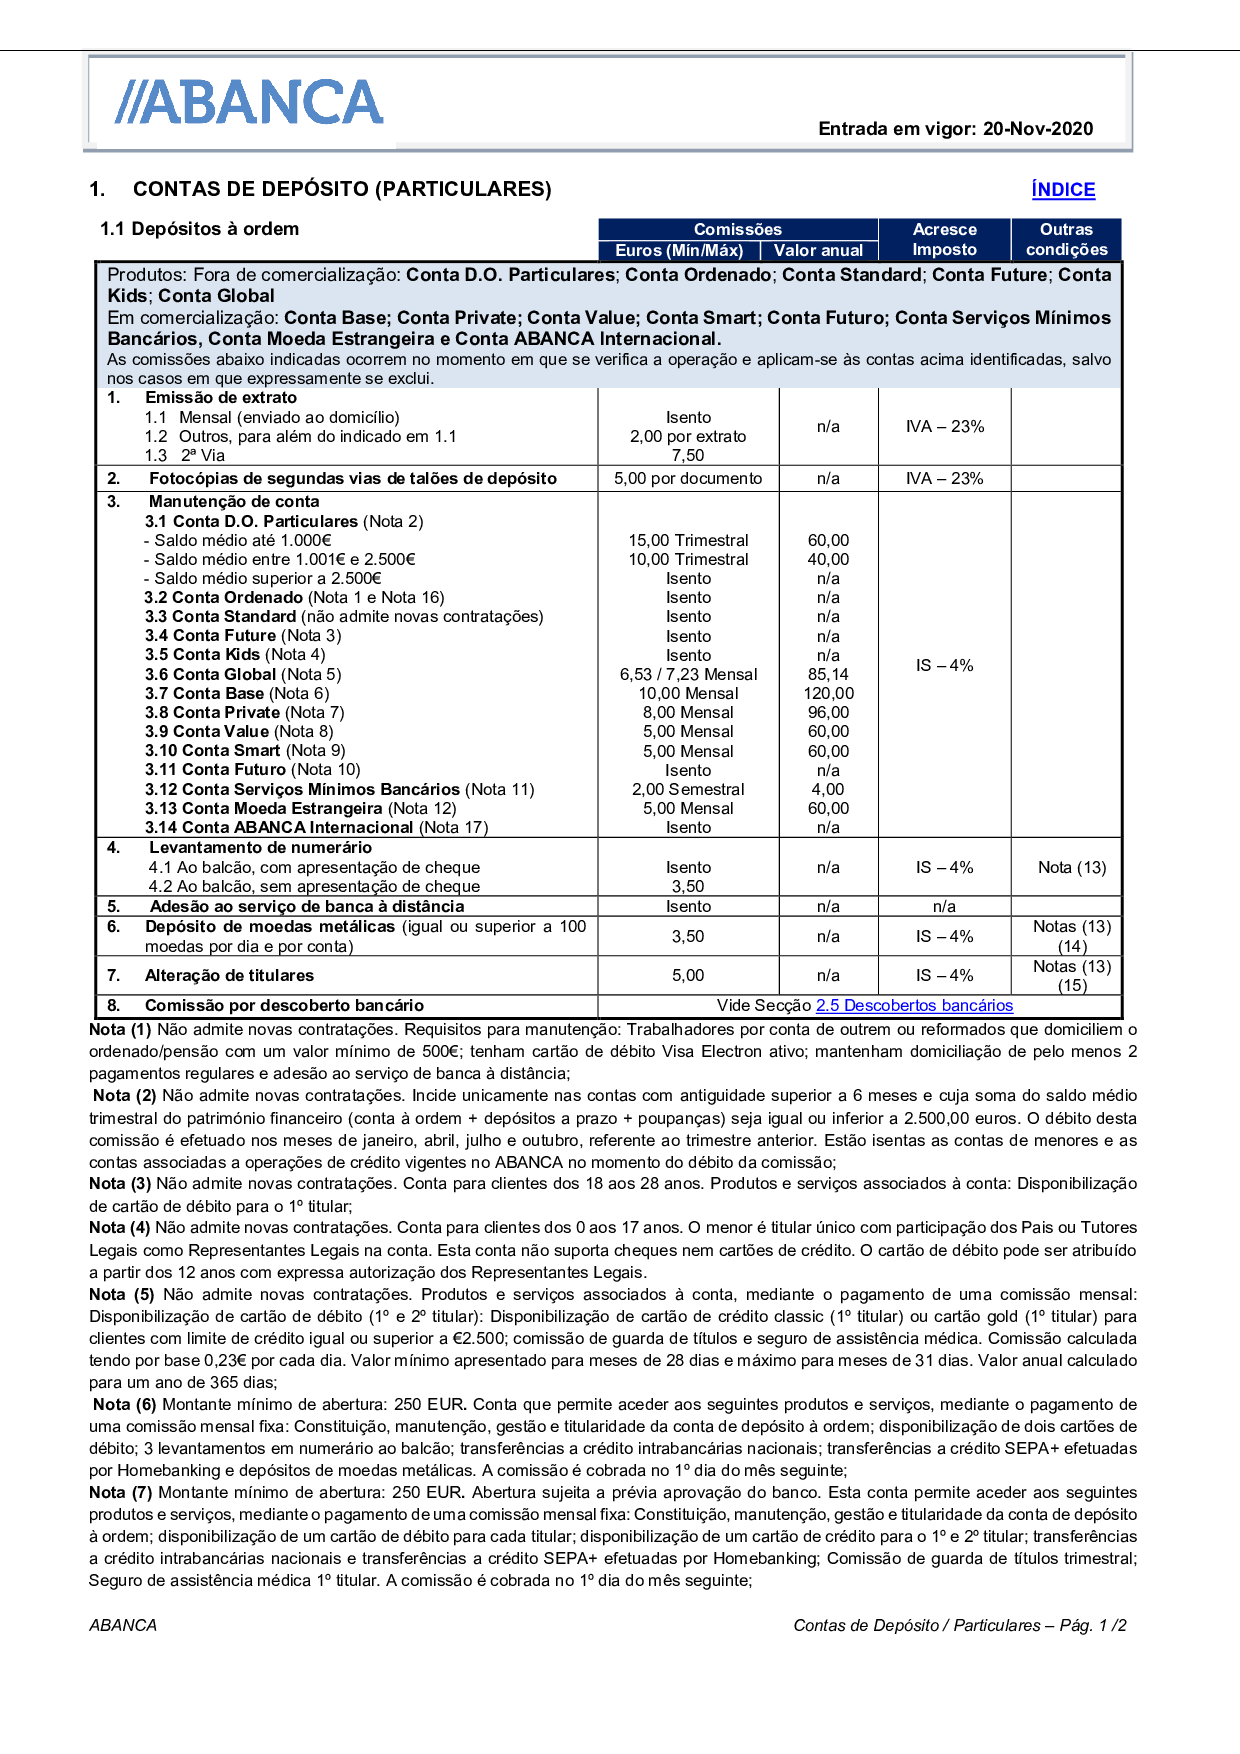

In [53]:
abanca = pdfplumber.open('data/abanca.pdf')
ctt = pdfplumber.open('data/ctt.pdf')
im_a = abanca.pages[4].to_image(resolution=150)
im_c = ctt.pages[4].to_image(resolution=150)
im_a

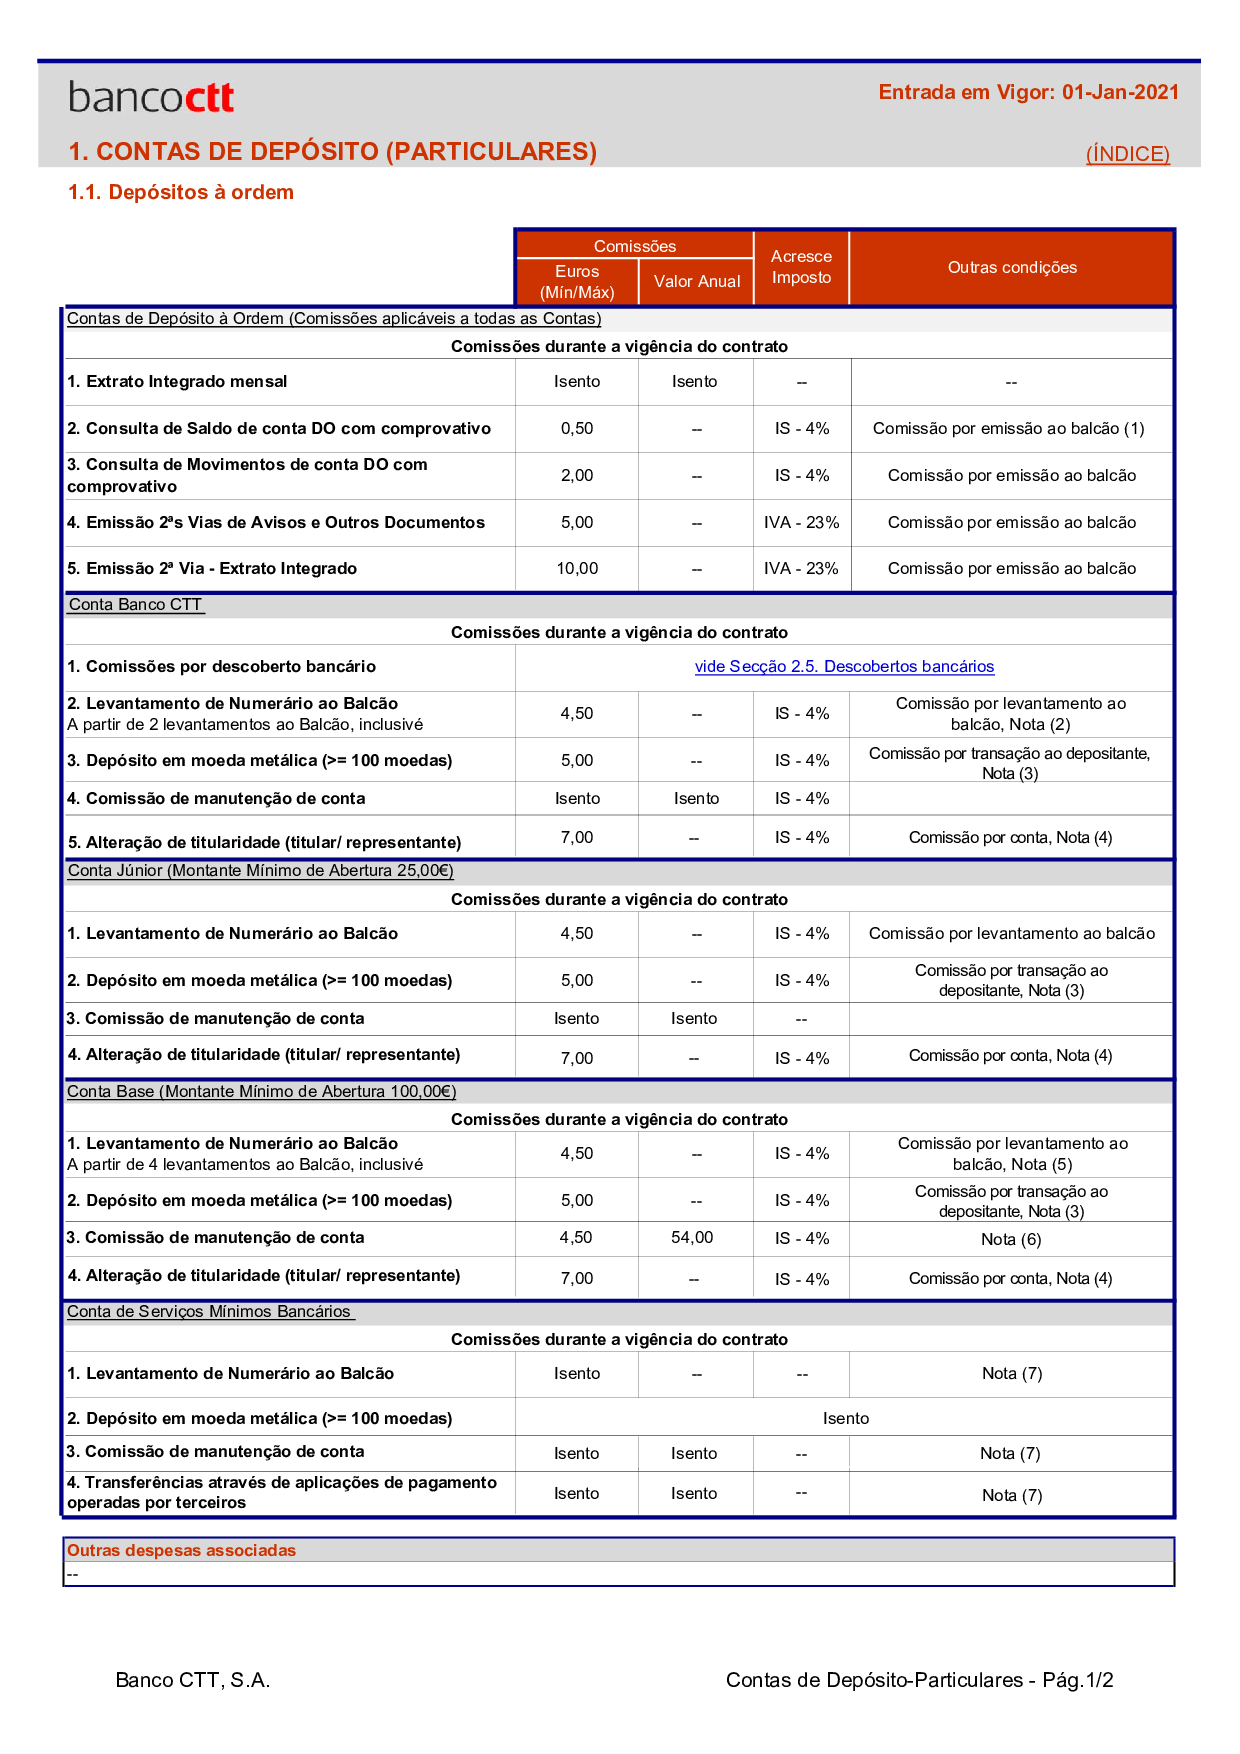

In [54]:
im_c

### Extracting text as a string

The function we built is differentiated by type of pdf file:
- is the file divided and readen by the nltk in sentences containig all the information
- is the file not divided in sentences with all the information we require


**Text before/after the functions**

In [72]:
original_text = abanca.pages[4].extract_text()
function_text = DemandDeposit('https://www.abanca.pt/files/documents/precario-folheto-comissoes-823a7663.pdf', [4])\
                                                            .tokenize()
original_text[:1000] , function_text[:10]

('Entrada em vigor: 20-Nov-2020 \n \n1.  CONTAS DE DEPÓSITO (PARTICULARES)                                                                                   ÍNDICE  \n1.1 Depósitos à ordem  Comissões  Acresce  Outras \n  Euros (Mín/Máx)  Valor anual  Imposto  condições \nProdutos: Fora de comercialização: Conta D.O. Particulares; Conta Ordenado; Conta Standard; Conta Future; Conta \nKids; Conta Global \nEm comercialização: Conta Base; Conta Private; Conta Value; Conta Smart; Conta Futuro; Conta Serviços Mínimos \nBancários, Conta Moeda Estrangeira e Conta ABANCA Internacional. \nAs comissões abaixo indicadas ocorrem no momento em que se verifica a operação e aplicam-se às contas acima identificadas, salvo \nnos casos em que expressamente se exclui.  \n1.  Emissão de extrato     \n1.1  Mensal (enviado ao domicílio)  Isento \nn/a  IVA – 23% \n1.2  Outros, para além do indicado em 1.1  2,00 por extrato \n1.3  2ª Via      7,50   \n2.   Fotocópias de segundas vias de talões de depósito   5,

### Extracting type of commisions and relative sentence:

- to do so we use a dictionary built from the pdfs file
- the function work even with more pages (1.1 in differents page of the pdf of prices)
- reconize if the page scraped is not the right now

In [85]:
# abanca_values = DemandDeposit('https://www.abanca.pt/files/documents/precario-folheto-comissoes-823a7663.pdf', [4])\
#                                                             .values()
abanca_values = DemandDeposit('https://www.abanca.pt/files/documents/precario-folheto-comissoes-823a7663.pdf', [5])\
                                                            .values()
abanca_values

'not the right page'

### Extracting names of subproducts:
The built function take divide the pdf file from their characteristic once again, based on the transformation done before

In [60]:
abanca_names = DemandDeposit('https://www.abanca.pt/files/documents/precario-folheto-comissoes-823a7663.pdf', [4])\
                                                            .names()

In [77]:
abanca_names

['Conta D.O.',
 'Conta Ordenado',
 'Conta Standard',
 'Conta Future',
 'Conta Kids',
 'Conta Global Em comercialização:',
 'Conta Base',
 'Conta Private',
 'Conta Value',
 'Conta Smart',
 'Conta Futuro',
 'Conta Serviços Mínimos Bancários,',
 'Conta Moeda Estrangeira e',
 'Conta ABANCA Internacional.',
 'Conta Moeda Estrangeira (Nota 12) 5,00 Mensal 60,00 4.',
 'Conta Pacote 4.1.',
 'Conta Global (Nota 5) 6,53 / 7,23 Mensal 85,14 4.4.',
 'Conta ABANCA Internacional (Nota 17) 0,00 nan 5.',
 'Conta Serviços Mínimos Bancários 2,00 Semestral 4,00 IS – 4% (Nota 11) 7.',
 'Conta para clientes dos 18 aos 28 anos.',
 'Conta para clientes dos 0 aos 17 anos.',
 'Conta que permite aceder aos seguintes produtos e serviços, mediante o pagamento de uma']

### Count total number of subproduct offered by the bank

In [78]:
abanca_total = DemandDeposit('https://www.abanca.pt/files/documents/precario-folheto-comissoes-823a7663.pdf', [4])\
                                                            .accounts_offer()
abanca_total

22

### final output

- final output of the scraping is a dictionary, that will be transformed in a json object
- in this dictionary we will, for each product show all the corrispective subproduct with the value of each type of commision

In [64]:
output = {'bank_id':{'demand_depos':
                             {'example_subproduct':
                                  {'name':
                                          {'statement' : None,
                                           'documents_copy' : None,
                                           'acc_manteinance' : None,
                                           'withdraw': None,
                                           'online_service' : None,
                                           'cash_deposit': None,
                                           'change_holder' : None,
                                           'bank_overdraft': None,
                                           'movement_consultation': None,
                                           'balance_inquiry': None}},
                             'n_subproducts': None},
                                     
                    'house_credit':{'example_subproduct':
                                        {'name':
                                            {'admin': None,
                                            'certificates': None,
                                            'debt_recovery' : None,
                                            'displacement' : None,
                                           'early_payment': None,
                                           'evaluation' : None,
                                           'formalization': None,
                                           'process' : None,
                                           'inspections': None,
                                           'reanalysis': None,
                                           'settlement': None,
                                            'solicitors_notary': None,
                                           'statements' : None,
                                           'taxes': None,
                                           'termination' : None}},
                                   'n_subproducts': None},
                     
                    'term_depos':{'subproduct' : 
                                              {'commission': None},
                                 'n_subproducts': None}
                    }
         }

In [65]:
abanca_dict = DemandDeposit("https://www.abanca.pt/files/documents/precario-folheto-comissoes-823a7663.pdf", [4])\
                .output()

In [80]:
abanca_dict

{'demand_depos': {'subroducts': {'Conta D.O.': {'statement': None,
    'documents_copy': None,
    'acc_manteinance': None,
    'withdraw': None,
    'online_service': None,
    'cash_deposit': None,
    'change_holder': None,
    'bank_overdraft': None,
    'movement_consultation': None,
    'balance_inquiry': None},
   'Conta Ordenado': {'statement': None,
    'documents_copy': None,
    'acc_manteinance': None,
    'withdraw': None,
    'online_service': None,
    'cash_deposit': None,
    'change_holder': None,
    'bank_overdraft': None,
    'movement_consultation': None,
    'balance_inquiry': None},
   'Conta Standard': {'statement': None,
    'documents_copy': None,
    'acc_manteinance': None,
    'withdraw': None,
    'online_service': None,
    'cash_deposit': None,
    'change_holder': None,
    'bank_overdraft': None,
    'movement_consultation': None,
    'balance_inquiry': None},
   'Conta Future': {'statement': None,
    'documents_copy': None,
    'acc_manteinance': No

### Housing product

#### dictionary

In [81]:
house_credit_com = {'admin':['Comissões associadas a atos administrativos 4.1 Não realização da escritura',
                             'Alteração do local da escritura',
                             'Declarações de dívida',
                             'Mudança de regime de crédito',
                             'Declarações de dívida',
                             'Pedido de 2ª via de Caderneta Predial',
                             'Emissão de declarações não obrigatórias por lei',
                             'Emissão de 2ª vias de Declaração para efeitos de IRS – Urgente',
                             'Emissão de 2º vias de Declaração para efeitos de IRS',
                             'Emissão de 2ª vias de faturas',
                             'Declaração de Dívida para Fins Diversos',
                             'Declaração de Encargos com Prestações'],
                    'certificates':['Emolumentos do registo predial', 'registo predial',
                                    'Certidão permanente on-line'],
                    'debt_recovery':['Comissão de recuperação de valores em dívida', 'Prestação até 50.000 €',
                                    'Prestação > 50.000 €', 'Comissão de recuperação de valores em dívida',
                                    'Prestação > 50.000,00€', 'Prestação ≤ 50.000,00€'],
                    'displacement':['Comissão de deslocação', 'Até 100 Kms', '101 a 250 Kms', '> 250 Kms '],
                    'early_payment':['Comissão de reembolso antecipado parcial', 'Taxa fixa', 'Taxa variável', 
                                    'Taxa fixa', 'Comissão de reembolso antecipado total', 'Comissão de antecipação',
                                    '(pré.aviso 7 dias)', 'Comissão de compra antecipada', '(pré-aviso 10 dias)', 
                                    'Comissão de Reembolso Antecipado Parcial',
                                    'Comissão de reembolso antecipado total'],
                    'evaluation':['Avaliação', 'Imóvel residencial', 
                                 'Garagens e arrecadações não anexas ao imóvel residencial', 'Avaliação do Imóvel'],
                    'formalization':['Comissão de formalização', 'Formalização'],
                    'process':['Processo', 'Abertura de Processo',
                              'Desistência ou não conclusão do processo por motivos imputáveis ao cliente'],
                    'inspections':['Vistorias', 'em caso de construção ou realização de obras'],
                    'reanalysis':['Reanálise'],
                    'settlement':['Comissão de Liquidação de Prestação', 'Liquidação de Prestação'],
                    'solicitors_notary':['Emolumentos notariais', 'Solicitadoria', 'Notiário'],
                    'statements':['Emissão de extratos de conta de empréstimos liquidados', 'extrato', 'extratos',
                                  'extrato de conta', 'extrato mensal'],
                    'taxes':['Imposto do Selo sobre concessão de crédito', 'imposto', 'imposto de selo', 'impostos'],
                    'termination':['Cessação da posição contratual', 'cessação', 'rescisão', 'encerramento']
                    }

#### actual dataframe

In [69]:
def get_prices(pdf,page, dictionary):
    doc = pdfplumber.open(pdf)
    prod_df=pd.DataFrame(doc.pages[page].extract_table())
    
    def find_prices(df,word):
        for x in range(df.shape[0]):
            for y in range(df.shape[1]):
                if word in str(df[y][x]):
                    return y
    
    def find_index(df,dictionary):
        index_col=list()
        for x in range(df.shape[0]):
            for y in range(df.shape[1]):
                if df[y][x]=='None':
                    pass
                else:
                    for key in dictionary.keys():
                        if df[y][x] in dictionary[key]:
                            index_col.append(y)
        return int(statistics.median(index_col))
    
    prices_col=find_prices(prod_df, 'Euros')
    index_col=find_index(prod_df, house_credit_com)
    
    prices_df=pd.DataFrame()
    prices_df['Commissions']=prod_df[index_col]
    prices_df['Prices']=prod_df[prices_col]
    
    def clean_df(df):
        for x in range(df.shape[0]):
            for y in df.columns:
                if str(df[y][x])=='' or str(df[y][x])=='None':
                    df[y][x]=np.nan
        return df.dropna(axis='columns', how='all').dropna(axis='rows', how='all')

    return clean_df(prices_df)

In [70]:
get_prices('data/bic.pdf', 8, house_credit_com)

,Commissions,Prices
2,2.1. Crédito à habitação e outros créditos hip...,NaN
5,NaN,Euros \n(Mín/Máx)
6,Crédito à Habitação com Garantia Hipotecária N...,NaN
7,Comissões iniciais,NaN
8,1. Comissão de processo,NaN
9,Habitação Própria,"260,00"
10,Habitação Própria (oferta sénior),"260,00"
11,Troca de Casa (Fora de comercialização),"260,00"
12,Troca de Banco,"260,00"
13,Habitação para Arrendamento,"260,00"
